<a href="https://colab.research.google.com/github/Gopib03/-My_Google_ADK_AI_Agents/blob/main/Training_RNNs_for_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

File ‘aclImdb_v1.tar.gz’ already there; not retrieving.



In [2]:
import os
import time
import numpy as np
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8" # Added to ensure deterministic behavior with CuBLAS
torch.use_deterministic_algorithms(True)

In [3]:
# read sentiments and reviews data from the text files
review_list = []
label_list = []
for label in ['pos', 'neg']:
    for fname in tqdm(os.listdir(
        f'./aclImdb/train/{label}/')):
        if 'txt' not in fname:
            continue
        with open(os.path.join(f'./aclImdb/train/{label}/',
                              fname), encoding="utf8") as f:
            review_list += [f.read()]
            label_list += [label]
print ('Number of reviews :', len(review_list))

100%|██████████| 12500/12500 [00:00<00:00, 44973.11it/s]

Number of reviews : 25000


In [4]:
# pre-processing review text
review_list = [review.lower() for review in review_list]
review_list = [''.join([letter for letter in review
                        if letter not in punctuation])
                        for review in tqdm(review_list)]
# accumulate all review texts together
reviews_blob = ' '.join(review_list)
# generate list of all words of all reviews
review_words = reviews_blob.split()
# get the word counts
count_words = Counter(review_words)
# sort words as per counts (decreasing order)
total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)
print(sorted_review_words[:10])


100%|██████████| 25000/25000 [00:01<00:00, 14817.09it/s]


[('the', 334691), ('and', 162228), ('a', 161940), ('of', 145326), ('to', 135042), ('is', 106855), ('in', 93028), ('it', 77099), ('i', 75719), ('this', 75190)]


In [5]:
# create word to integer (token) dictionary
# in order to encode text as numbers
vocab_to_token = {word:idx+1 for idx,
                  (word, count) in enumerate(sorted_review_words)}
print(list(vocab_to_token.items())[:10])


[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('in', 7), ('it', 8), ('i', 9), ('this', 10)]


In [6]:
reviews_tokenized = []
for review in review_list:
    word_to_token = [vocab_to_token[word] for word in
                     review.split()]
    reviews_tokenized.append(word_to_token)
print(review_list[0])
print()
print (reviews_tokenized[0])


i really dont understand why people get so upset and pan this movie remember folks this is an snl movie not anything that is supposed to be unpredictable and original in plot or direction the ladies man is a hilarious movie albeit stupid at times with a wackedout cast and as usual wonderful performances by will ferrel and tim meadows yes some of the jokes are stupid and yes the characters are unbelievable but its comedy i really dont understand how anyone couldnt laugh a lot during this hilarious film anyway all i ask is that people take this as it isan snl silly and irreverent comedy nothing that will win awards but nonetheless some modern comedy gold 104 apricot

[9, 62, 89, 372, 133, 82, 75, 37, 2975, 2, 5137, 10, 17, 363, 1550, 10, 6, 33, 4393, 17, 21, 227, 11, 6, 401, 5, 27, 5028, 2, 197, 7, 113, 41, 462, 1, 1772, 132, 6, 3, 649, 17, 2991, 374, 30, 210, 16, 3, 36644, 176, 2, 14, 618, 373, 346, 32, 76, 26241, 2, 1680, 7739, 412, 46, 4, 1, 633, 23, 374, 2, 412, 1, 101, 23, 1301, 18,

In [7]:
# encode sentiments as 0 or 1
encoded_label_list = [1 if label =='pos'
                      else 0 for label in label_list]
reviews_len = [len(review) for review in reviews_tokenized]
reviews_tokenized = [reviews_tokenized[i]
                     for i, l in enumerate(reviews_len)
                     if l>0 ]
encoded_label_list = np.array([encoded_label_list[i]
                              for i, l in enumerate(reviews_len)
                              if l> 0 ], dtype='float32')

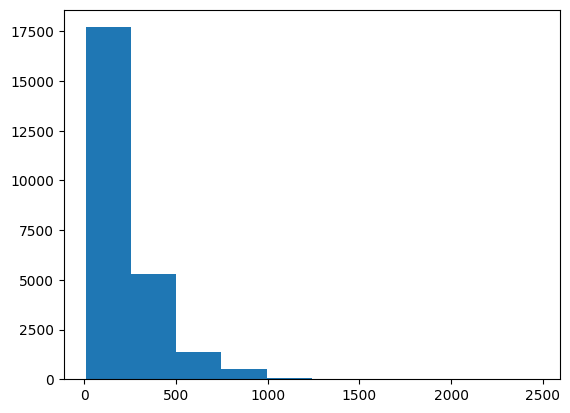

In [8]:
def pad_sequence(reviews_tokenized, sequence_length):
    ''' returns the tokenized review sequences padded
        with ''s or truncated to the sequence_length.'''
    padded_reviews = np.zeros((len(reviews_tokenized),
                               sequence_length),
                               dtype = int)
    for idx, review in enumerate(reviews_tokenized):
        review_len = len(review)
        if review_len <= sequence_length:
            zeroes = list(np.zeros(
                sequence_length-review_len))
            new_sequence = zeroes+review
        elif review_len > sequence_length:
            new_sequence = review[0:sequence_length]
        padded_reviews[idx,:] = np.array(new_sequence)
    return padded_reviews
sequence_length = 512
padded_reviews = pad_sequence(reviews_tokenized=reviews_tokenized,
             sequence_length=sequence_length)
plt.hist(reviews_len);

In [9]:
train_val_split = 0.75
train_X = \
    padded_reviews[:int(
        train_val_split*len(padded_reviews))]
train_y = \
    encoded_label_list[:int(
        train_val_split*len(padded_reviews))]
validation_X = \
    padded_reviews[int(
        train_val_split*len(padded_reviews)):]
validation_y = \
    encoded_label_list[int(
        train_val_split*len(padded_reviews)):]


In [10]:
# generate torch datasets
train_dataset = TensorDataset(
    torch.from_numpy(train_X).to(device),
    torch.from_numpy(train_y).to(device))
validation_dataset = TensorDataset(
    torch.from_numpy(validation_X).to(device),
    torch.from_numpy(validation_y).to(device))
batch_size = 32
# torch dataloaders (shuffle data)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=True)


In [11]:
# get a batch of train data
train_data_iter = iter(train_dataloader)
X_example, y_example = next(train_data_iter)
# batch_size, seq_length
print('Example Input size: ', X_example.size())
print('Example Input:\n', X_example)
print()
# batch_size
print('Example Output size: ', y_example.size())
print('Example Output:\n', y_example)


Example Input size:  torch.Size([32, 512])
Example Input:
 tensor([[   0,    0,    0,  ...,   96,   16,   39],
        [   0,    0,    0,  ...,   92,   65,   90],
        [   0,    0,    0,  ...,  949,  147,  597],
        ...,
        [   0,    0,    0,  ...,    7, 1150,  366],
        [   0,    0,    0,  ..., 9637,   12, 2366],
        [   0,    0,    0,  ...,   14,  581,  260]], device='cuda:0')

Example Output size:  torch.Size([32])
Example Output:
 tensor([0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.],
       device='cuda:0')


Instantiating and training the model

In [12]:
class RNN(nn.Module):
    def __init__(self, input_dimension, embedding_dimension,
                 hidden_dimension, output_dimension):
        super().__init__()
        self.embedding_layer = nn.Embedding(input_dimension,
                                        embedding_dimension)
        self.rnn_layer = nn.RNN(embedding_dimension,
                                hidden_dimension,
                                num_layers=1)
        self.fc_layer = nn.Linear(hidden_dimension,
                                  output_dimension)
    def forward(self, sequence):
        # sequence shape = (sequence_length, batch_size)
        embedding = self.embedding_layer(sequence)
        # embedding shape = [sequence_length, batch_size,
        #                    embedding_dimension]
        output, hidden_state = self.rnn_layer(embedding)
        # output shape = [sequence_length, batch_size,
        #                 hidden_dimension]
        # hidden_state shape = [1, batch_size,
        #                      hidden_dimension]
        final_output = self.fc_layer(
            hidden_state[-1,:,:].squeeze(0))
        return final_output


 instantiating the RNN model

In [13]:
input_dimension = len(vocab_to_token)+1
# +1 to account for padding
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1
rnn_model = RNN(input_dimension, embedding_dimension,
                hidden_dimension, output_dimension)
optimizer_instance = optim.Adam(rnn_model.parameters()) # Renamed to avoid collision
loss_func = nn.BCEWithLogitsLoss()
rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

In [14]:
def accuracy_metric(predictions, ground_truth):
    """
    Returns 0-1 accuracy for the given set
    of predictions and ground truth
    """
    # round predictions to either 0 or 1
    rounded_predictions = \
        torch.round(torch.sigmoid(predictions))
    # convert into float for division
    success = (rounded_predictions == ground_truth).float()
    accuracy = success.sum() / len(success)
    return accuracy


In [15]:
def train(model, dataloader, optimizer, loss_func):
    loss = 0
    accuracy = 0
    model.train()
    for sequence, sentiment in dataloader:
        optimizer.zero_grad()
        preds = model(sequence.T).squeeze()
        loss_curr = loss_func(preds, sentiment)
        accuracy_curr = accuracy_metric(preds, sentiment)
        loss_curr.backward()
        optimizer.step()
        loss += loss_curr.item()
        accuracy += accuracy_curr.item()
    return loss/len(dataloader), accuracy/len(dataloader)

The code for the validation routine is as follows:

In [16]:
def validate(model, dataloader, loss_func):
    loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for sequence, sentiment in dataloader:
            preds = model(sequence.T).squeeze()
            loss_curr = loss_func(preds, sentiment)
            accuracy_curr = accuracy_metric(preds, sentiment)
            loss += loss_curr.item()
            accuracy += accuracy_curr.item()
    return loss/len(dataloader), accuracy/len(dataloader)


now ready to train the model:

In [17]:
num_epochs = 10
best_validation_loss = float('inf')
for ep in range(num_epochs):
    time_start = time.time()
    training_loss, train_accuracy = train(rnn_model,
                                          train_dataloader,
                                          optimizer_instance, loss_func) # Used the renamed optimizer instance
    validation_loss, validation_accuracy = validate(
        rnn_model, validation_dataloader, loss_func)
    time_end = time.time()
    time_delta = time_end - time_start
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(rnn_model.state_dict(), 'rnn_model.pt')
    print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
    print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
    print(f'\tvalidation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')

epoch number: 1 | time elapsed: 2.919912576675415s
training loss: 0.630 | training accuracy: 66.00%
	validation loss: 1.037 |  validation accuracy: 14.54%
epoch number: 2 | time elapsed: 2.323291540145874s
training loss: 0.545 | training accuracy: 72.90%
	validation loss: 0.800 |  validation accuracy: 61.82%
epoch number: 3 | time elapsed: 2.362712860107422s
training loss: 0.465 | training accuracy: 78.61%
	validation loss: 1.119 |  validation accuracy: 40.45%
epoch number: 4 | time elapsed: 2.2874372005462646s
training loss: 0.392 | training accuracy: 82.79%
	validation loss: 0.864 |  validation accuracy: 59.15%
epoch number: 5 | time elapsed: 2.3015663623809814s
training loss: 0.317 | training accuracy: 87.02%
	validation loss: 0.885 |  validation accuracy: 63.38%
epoch number: 6 | time elapsed: 2.29837965965271s
training loss: 0.290 | training accuracy: 88.53%
	validation loss: 0.737 |  validation accuracy: 71.53%
epoch number: 7 | time elapsed: 2.318136215209961s
training loss: 0.2

 Helper function to make a real-time inference on the trained model:

In [18]:
def sentiment_inference(model, sentence):
    model.eval()
    # text transformations
    sentence = sentence.lower()
    sentence = ''.join([c for c in sentence
                       if c not in punctuation])
    tokenized = [vocab_to_token.get(token, 0)
                 for token in sentence.split()]
    tokenized = np.pad(tokenized,
                       (512-len(tokenized), 0), 'constant')
    # model inference
    model_input = torch.LongTensor(tokenized).to(device)
    model_input = model_input.unsqueeze(1)
    pred = torch.sigmoid(model(model_input))
    return pred.item()


 we will test the performance of this model on some manually entered review texts:

In [19]:
print(sentiment_inference(rnn_model,
                          "This film is horrible"))
print(sentiment_inference(rnn_model,
                          "Director tried too hard but \
                           this film is bad"))
print(sentiment_inference(rnn_model,
                          "This film will be houseful for weeks"))
print(sentiment_inference(rnn_model,
                          " I just really loved the movie"))


0.1330304890871048
0.29101577401161194
0.9749279022216797
0.9743750095367432
